# Data Preparation

In [1]:
import os
import numpy as np
from typing import Tuple, Dict, List
from tqdm import tqdm
import random

import torch
import torch.nn as nn 
from torch.nn import DataParallel
from torch.optim import Optimizer, AdamW

from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import matplotlib.pyplot as plt

from imagenette_dataset import ImageNetteDataset, train_val_split
from trainer import train
from models.VGG import VGG, VGG_Block
from utils import get_random_images, plot_predictions, plot_confusion_matrix

In [2]:
def download_data():
    if not os.path.exists('data'):
        os.makedir('data')

    if not os.listdir('data'):
        !wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz
        !tar -xzvf 'imagenette2.tgz' -C 'data'

download_data()

In [3]:
random_seed = 0
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device_ids = [0, 1, 2, 3, 4, 5, 6]
device

device(type='cuda', index=0)

In [4]:
train_dataset, val_dataset = train_val_split(
    dataset=ImageNetteDataset(root_dir='data/imagenette2/train'), 
    val_size=0.2
)
test_dataset = ImageNetteDataset(root_dir='data/imagenette2/val')

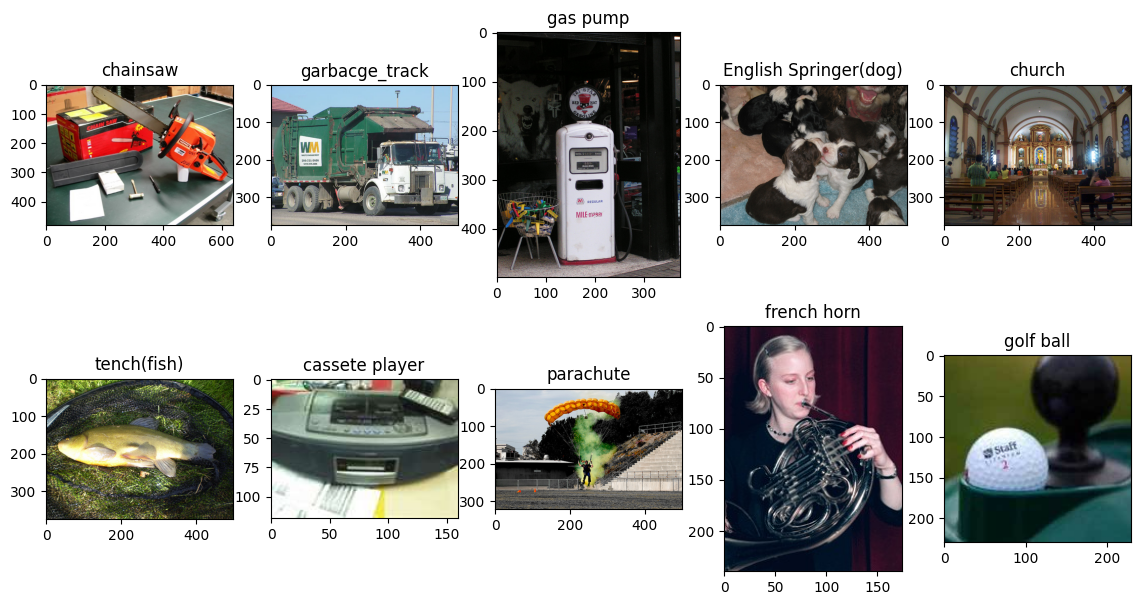

In [5]:
train_dataset.dataset.random_data_examples()

In [6]:
batch_size = 128
n_workers = 8

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=n_workers)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=n_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=n_workers)

# Training

## Without BN

In [7]:
vgg_model_11 = DataParallel(VGG(VGG_Block, n_layers=11, num_classes=10).to(device), device_ids=[0,1,2,3,4,5,6])
vgg_model_13 = DataParallel(VGG(VGG_Block, n_layers=13, num_classes=10).to(device), device_ids=[0,1,2,3,4,5,6])
vgg_model_16 = DataParallel(VGG(VGG_Block, n_layers=16, num_classes=10).to(device), device_ids=[0,1,2,3,4,5,6])
vgg_model_19 = DataParallel(VGG(VGG_Block, n_layers=19, num_classes=10).to(device), device_ids=[0,1,2,3,4,5,6])

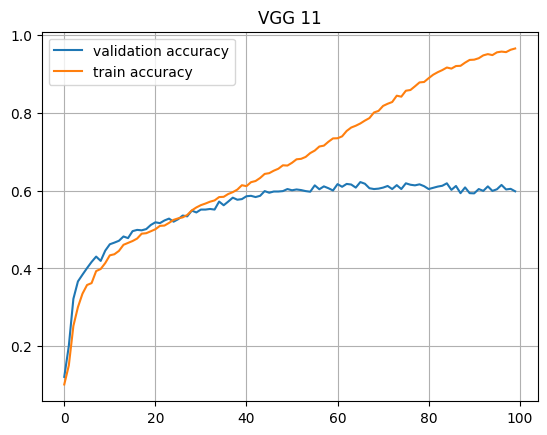

Validation accuracy: 0.598, best_val_acc: 0.622


Testing: 100%|██████████| 31/31 [00:04<00:00,  6.64it/s, accuracy=0.597]


Test accuracy of VGG 11 = 0.5969426751592357


In [8]:
n_epochs = 100
lr = 5*1e-6
criterion = nn.CrossEntropyLoss()

optimizer = AdamW(vgg_model_11.parameters(), lr=lr, weight_decay=0.1)
scheduler = ReduceLROnPlateau(optimizer, factor=0.5)

result_vgg_11 = train(vgg_model_11, 
                    train_dataloader, 
                    val_dataloader, 
                    test_dataloader,
                    optimizer, 
                    criterion,
                    device, 
                    scheduler,
                    n_epochs, 
                    title='VGG 11')


del vgg_model_11
torch.cuda.empty_cache()

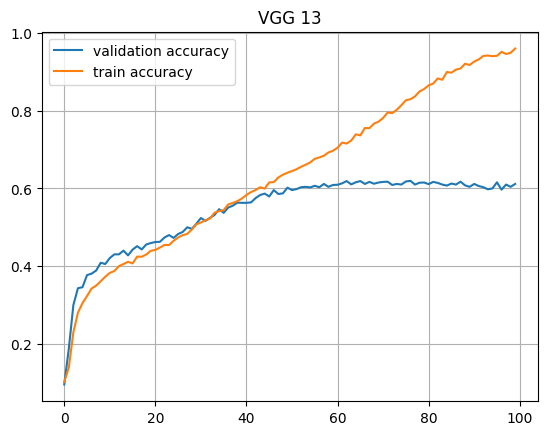

Validation accuracy: 0.611, best_val_acc: 0.619


Testing: 100%|██████████| 31/31 [00:04<00:00,  6.65it/s, accuracy=0.601]


Test accuracy of VGG 13 = 0.6012738853503184


In [9]:
optimizerget_random_imagesmW(vgg_model_13.parameters(), lr=lr, weight_decay=0.1)
scheduler = ReduceLROnPlateau(optimizer, factor=0.5)

result_vgg_13 = train(vgg_model_13, 
                    train_dataloader, 
                    val_dataloader, 
                    test_dataloader,
                    optimizer, 
                    criterion,
                    device, 
                    scheduler,
                    n_epochs, 
                    title='VGG 13')


del vgg_model_13
torch.cuda.empty_cache()

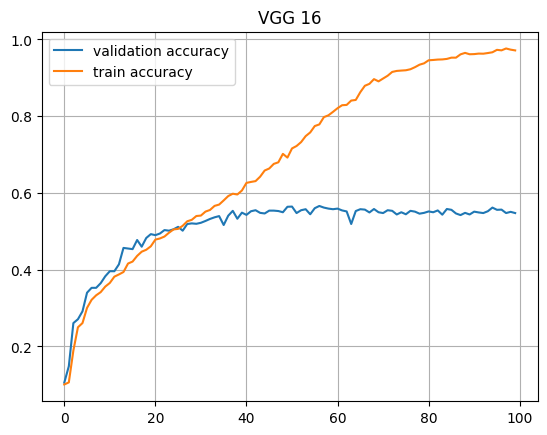

Validation accuracy: 0.548, best_val_acc: 0.566


Testing: 100%|██████████| 31/31 [00:04<00:00,  6.66it/s, accuracy=0.535]

Test accuracy of VGG 16 = 0.5345222929936305


In [10]:
optimizer = AdamW(vgg_model_16.parameters(), lr=lr, weight_decay=0.1)
scheduler = ReduceLROnPlateau(optimizer, factor=0.5)

result_vgg_16 = train(vgg_model_16, 
                    train_dataloader, 
                    val_dataloader, 
                    test_dataloader,
                    optimizer, 
                    criterion,
                    device, 
                    scheduler,
                    n_epochs, 
                    title='VGG 16')


del vgg_model_16
torch.cuda.empty_cache()

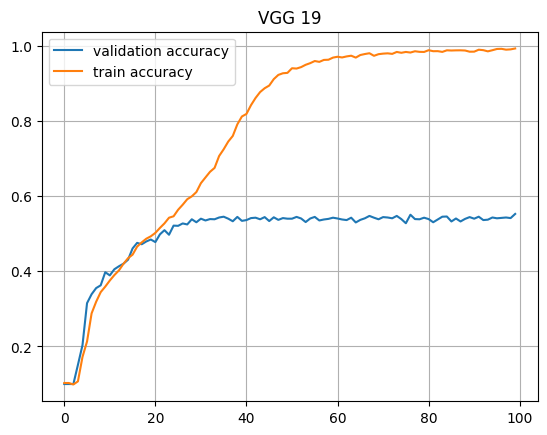

Validation accuracy: 0.553, best_val_acc: 0.553


Testing: 100%|██████████| 31/31 [00:05<00:00,  6.18it/s, accuracy=0.509]

Test accuracy of VGG 19 = 0.5092993630573248


In [11]:
optimizer = AdamW(vgg_model_19.parameters(), lr=lr, weight_decay=0.1)
scheduler = ReduceLROnPlateau(optimizer, factor=0.5)

result_vgg_19 = train(vgg_model_19, 
                    train_dataloader, 
                    val_dataloader, 
                    test_dataloader,
                    optimizer, 
                    criterion,
                    device, 
                    scheduler,
                    n_epochs, 
                    title='VGG 19')


del vgg_model_19
torch.cuda.empty_cache()

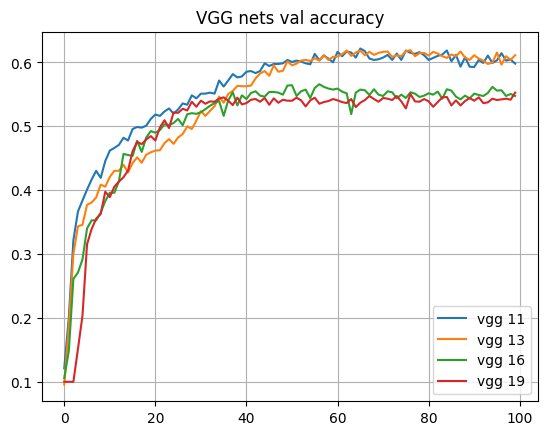

In [12]:
plt.plot(range(n_epochs), result_vgg_11['val_acc'], label='vgg 11')
plt.plot(range(n_epochs), result_vgg_13['val_acc'], label='vgg 13')
plt.plot(range(n_epochs), result_vgg_16['val_acc'], label='vgg 16')
plt.plot(range(n_epochs), result_vgg_19['val_acc'], label='vgg 19')
plt.title(label='VGG nets val accuracy')
plt.grid()
plt.legend()
plt.show()

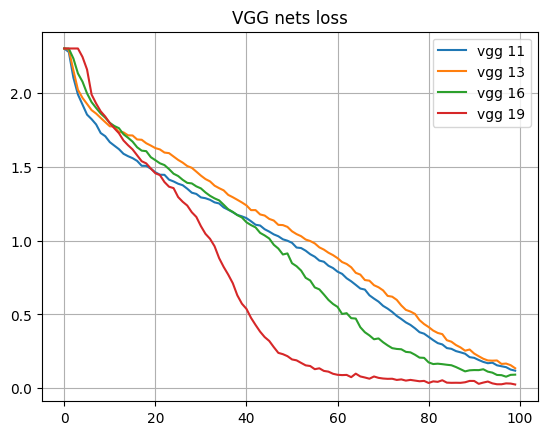

In [13]:
plt.plot(range(n_epochs), result_vgg_11['all_loss'], label='vgg 11')
plt.plot(range(n_epochs), result_vgg_13['all_loss'], label='vgg 13')
plt.plot(range(n_epochs), result_vgg_16['all_loss'], label='vgg 16')
plt.plot(range(n_epochs), result_vgg_19['all_loss'], label='vgg 19')
plt.title(label='VGG nets loss')
plt.grid()
plt.legend()
plt.show()

In [15]:
test_acc_11 = result_vgg_11['test_acc']
test_acc_13 = result_vgg_13['test_acc']
test_acc_16 = result_vgg_16['test_acc']
test_acc_19 = result_vgg_19['test_acc']

print(f'Test accuracies \nVGG 11: {test_acc_11} \
    \nVGG 13: {test_acc_13} \
    \nVGG 16: {test_acc_16} \
    \nVGG 19: {test_acc_19}')

Test accuracies 
VGG 11: 0.5969426751592357     
VGG 13: 0.6012738853503184     
VGG 16: 0.5345222929936305     
VGG 19: 0.5092993630573248


## With BN

In [16]:
vgg_model_11_bn = DataParallel(VGG(VGG_Block, n_layers=11, num_classes=10, use_batch_norm=True).to(device), device_ids=[0,1,2,3,4,5,6])
vgg_model_13_bn = DataParallel(VGG(VGG_Block, n_layers=13, num_classes=10, use_batch_norm=True).to(device), device_ids=[0,1,2,3,4,5,6])
vgg_model_16_bn = DataParallel(VGG(VGG_Block, n_layers=16, num_classes=10, use_batch_norm=True).to(device), device_ids=[0,1,2,3,4,5,6])
vgg_model_19_bn = DataParallel(VGG(VGG_Block, n_layers=19, num_classes=10, use_batch_norm=True).to(device), device_ids=[0,1,2,3,4,5,6])

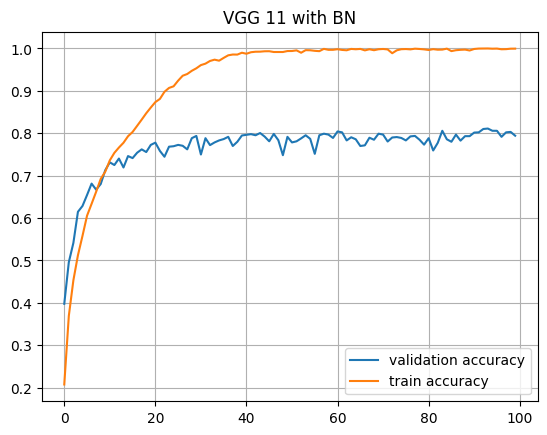

Validation accuracy: 0.794, best_val_acc: 0.811


Testing: 100%|██████████| 31/31 [00:04<00:00,  6.22it/s, accuracy=0.772]


Test accuracy of VGG 11 with BN = 0.77171974522293


In [17]:
n_epochs = 100
lr = 5*1e-6
criterion = nn.CrossEntropyLoss()

optimizer = AdamW(vgg_model_11_bn.parameters(), lr=lr, weight_decay=0.1)
scheduler = ReduceLROnPlateau(optimizer, factor=0.5)

result_vgg_11_bn = train(vgg_model_11_bn, 
                    train_dataloader, 
                    val_dataloader, 
                    test_dataloader,
                    optimizer, 
                    criterion,
                    device, 
                    scheduler,
                    n_epochs, 
                    title='VGG 11 with BN')


del vgg_model_11_bn
torch.cuda.empty_cache()

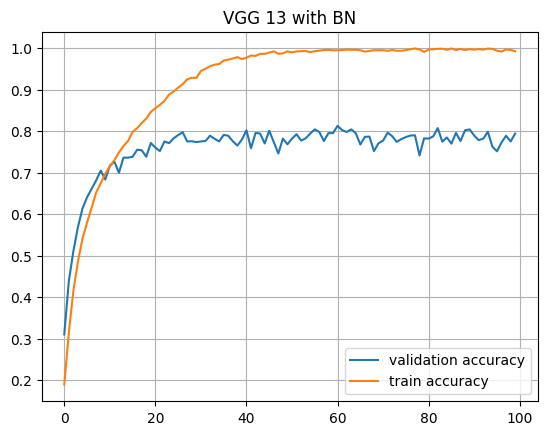

Validation accuracy: 0.794, best_val_acc: 0.813


Testing: 100%|██████████| 31/31 [00:04<00:00,  6.21it/s, accuracy=0.774]

Test accuracy of VGG 13 with BN = 0.7735031847133758


In [18]:
optimizer = AdamW(vgg_model_13_bn.parameters(), lr=lr, weight_decay=0.1)
scheduler = ReduceLROnPlateau(optimizer, factor=0.5)

result_vgg_13_bn = train(vgg_model_13_bn, 
                    train_dataloader, 
                    val_dataloader, 
                    test_dataloader,
                    optimizer, 
                    criterion,
                    device, 
                    scheduler,
                    n_epochs, 
                    title='VGG 13 with BN')


del vgg_model_13_bn
torch.cuda.empty_cache()

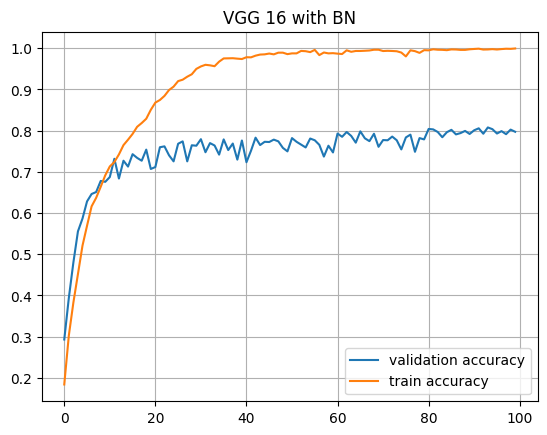

Validation accuracy: 0.797, best_val_acc: 0.808


Testing: 100%|██████████| 31/31 [00:05<00:00,  5.97it/s, accuracy=0.766]


Test accuracy of VGG 16 with BN = 0.7663694267515924


In [22]:
optimizer = AdamW(vgg_model_16_bn.parameters(), lr=lr, weight_decay=0.1)
scheduler = ReduceLROnPlateau(optimizer, factor=0.5)

result_vgg_16_bn = train(vgg_model_16_bn, 
                    train_dataloader, 
                    val_dataloader, 
                    test_dataloader,
                    optimizer, 
                    criterion,
                    device, 
                    scheduler,
                    n_epochs, 
                    title='VGG 16 with BN')


del vgg_model_16_bn
torch.cuda.empty_cache()

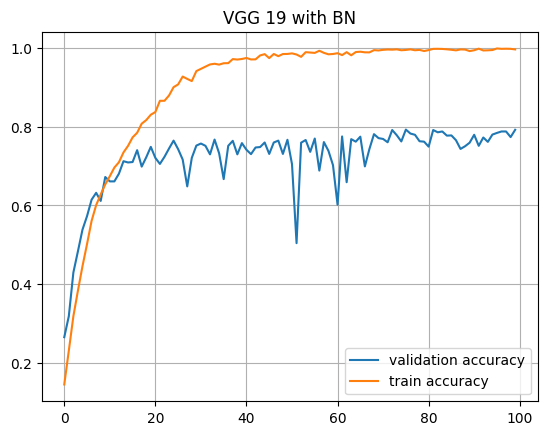

Validation accuracy: 0.792, best_val_acc: 0.793


Testing: 100%|██████████| 31/31 [00:04<00:00,  6.57it/s, accuracy=0.764]


Test accuracy of VGG 19 with BN = 0.7640764331210191


In [23]:
optimizer = AdamW(vgg_model_19_bn.parameters(), lr=lr, weight_decay=0.1)
scheduler = ReduceLROnPlateau(optimizer, factor=0.5)

result_vgg_19_bn = train(vgg_model_19_bn, 
                    train_dataloader, 
                    val_dataloader, 
                    test_dataloader,
                    optimizer, 
                    criterion,
                    device, 
                    scheduler,
                    n_epochs, 
                    title='VGG 19 with BN')


del vgg_model_19_bn
torch.cuda.empty_cache()

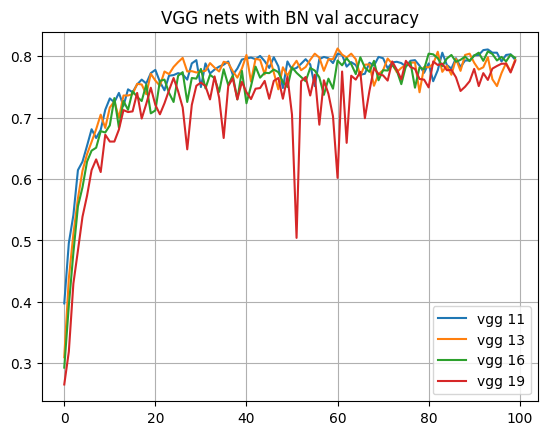

In [24]:
plt.plot(range(n_epochs), result_vgg_11_bn['val_acc'], label='vgg 11')
plt.plot(range(n_epochs), result_vgg_13_bn['val_acc'], label='vgg 13')
plt.plot(range(n_epochs), result_vgg_16_bn['val_acc'], label='vgg 16')
plt.plot(range(n_epochs), result_vgg_19_bn['val_acc'], label='vgg 19')
plt.title(label='VGG nets with BN val accuracy')
plt.grid()
plt.legend()
plt.show()

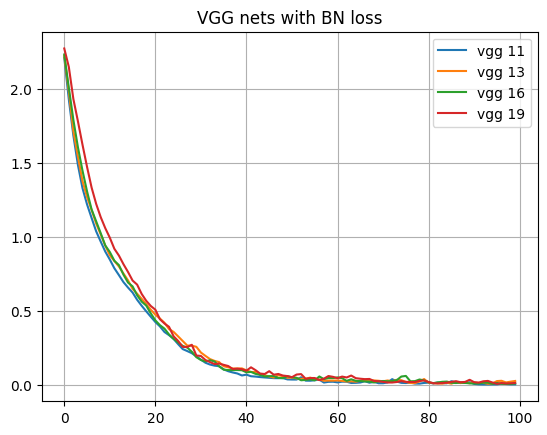

In [25]:
plt.plot(range(n_epochs), result_vgg_11_bn['all_loss'], label='vgg 11')
plt.plot(range(n_epochs), result_vgg_13_bn['all_loss'], label='vgg 13')
plt.plot(range(n_epochs), result_vgg_16_bn['all_loss'], label='vgg 16')
plt.plot(range(n_epochs), result_vgg_19_bn['all_loss'], label='vgg 19')
plt.title(label='VGG nets with BN loss')
plt.grid()
plt.legend()
plt.show()

In [26]:
test_acc_11 = result_vgg_11_bn['test_acc']
test_acc_13 = result_vgg_13_bn['test_acc']
test_acc_16 = result_vgg_16_bn['test_acc']
test_acc_19 = result_vgg_19_bn['test_acc']

print(f'Test accuracies with BN \nVGG 11: {test_acc_11} \
    \nVGG 13: {test_acc_13} \
    \nVGG 16: {test_acc_16} \
    \nVGG 19: {test_acc_19}')

Test accuracies with BN 
VGG 11: 0.77171974522293     
VGG 13: 0.7735031847133758     
VGG 16: 0.7663694267515924     
VGG 19: 0.7640764331210191


# Plot predictions of top models

In [27]:
vgg_13 = DataParallel(VGG(VGG_Block, n_layers=13, num_classes=10, use_batch_norm=False).to(device), device_ids=[0,1,2,3,4,5,6])
vgg_13_bn = DataParallel(VGG(VGG_Block, n_layers=13, num_classes=10, use_batch_norm=True).to(device), device_ids=[0,1,2,3,4,5,6])
vgg_13.load_state_dict(result_vgg_13['best_state'])
vgg_13_bn.load_state_dict(result_vgg_13_bn['best_state'])

<All keys matched successfully>

In [39]:
random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)

In [40]:
images = get_random_images()

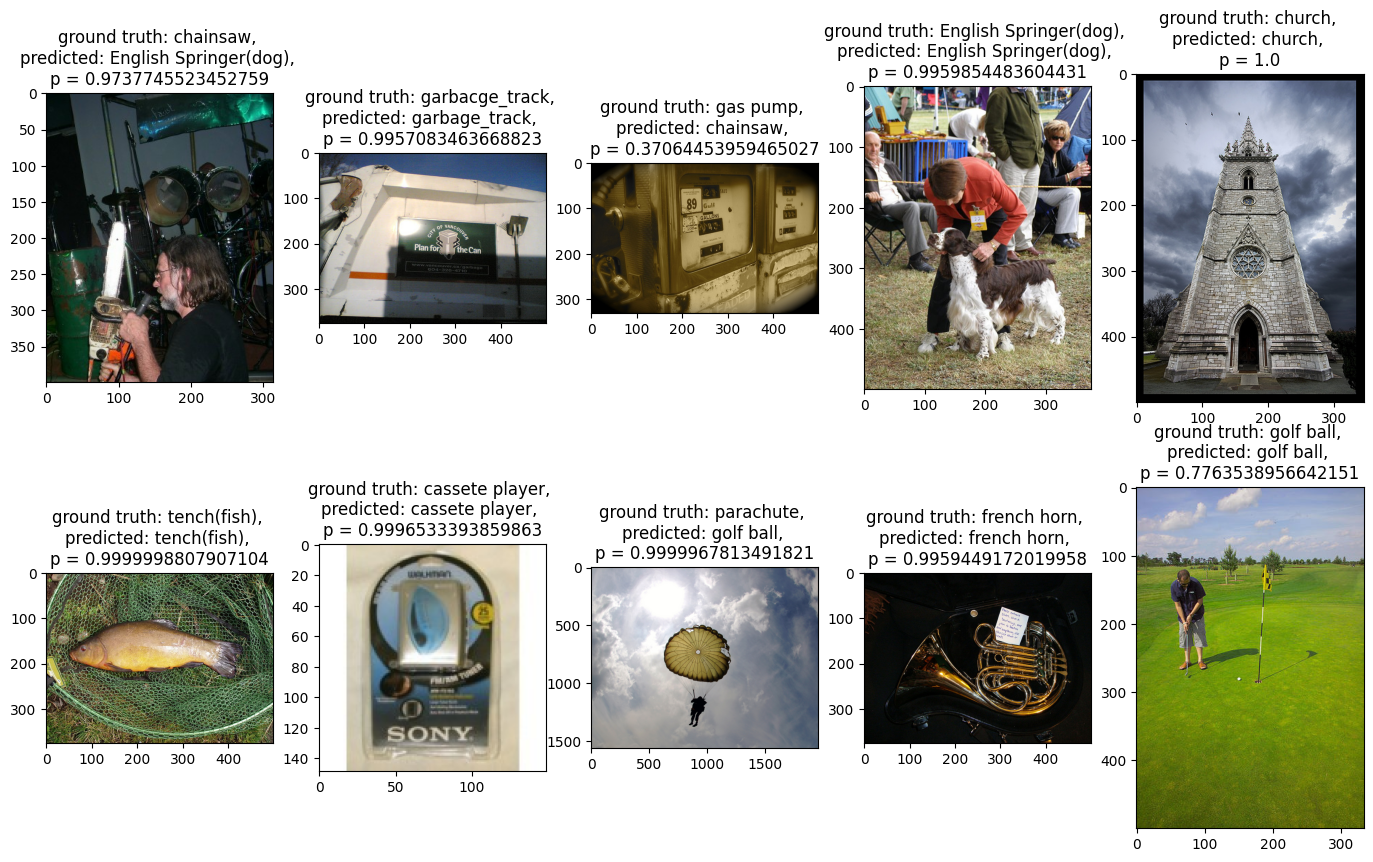

In [41]:
plot_predictions(vgg_13.module, images, device)

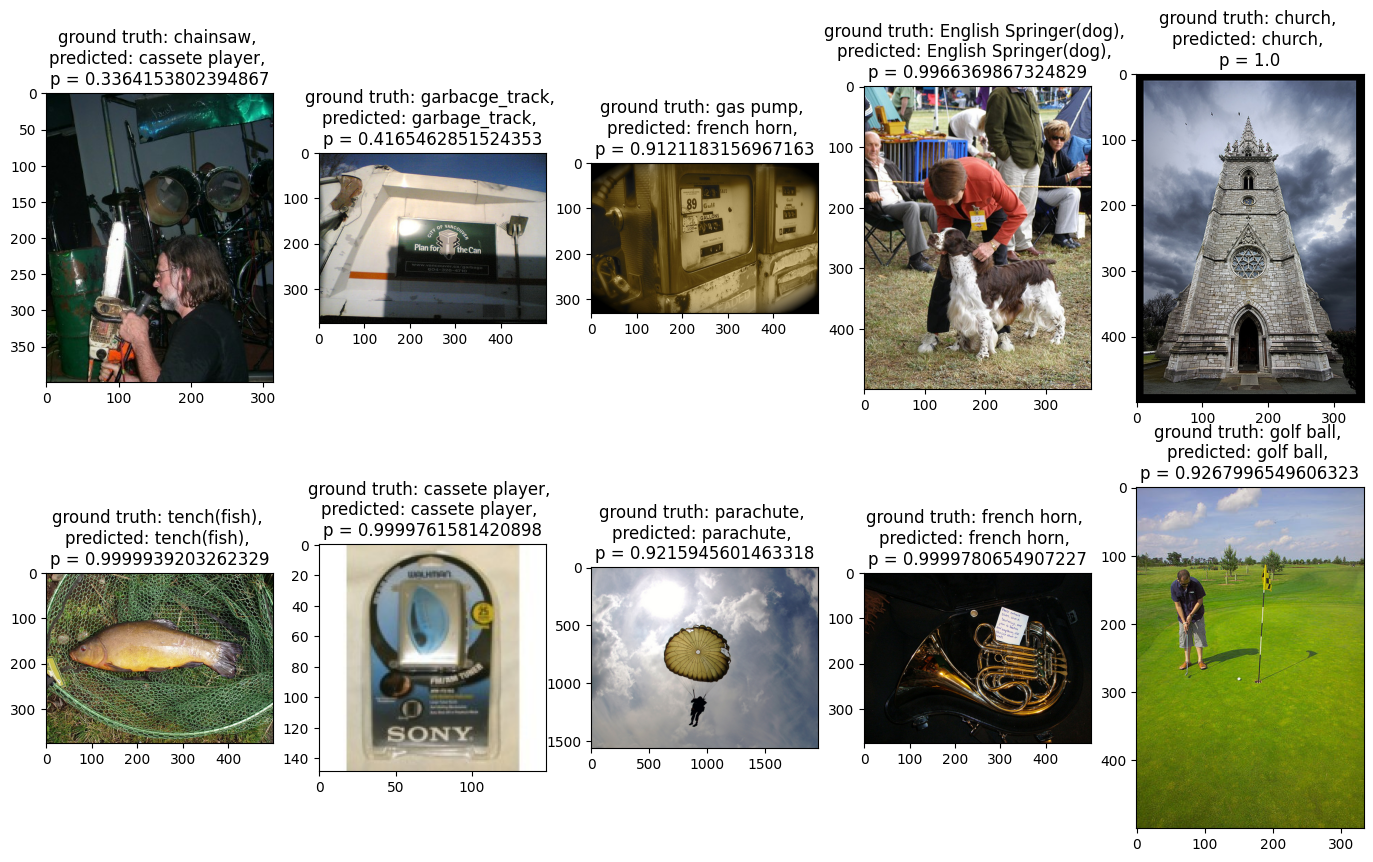

In [42]:
plot_predictions(vgg_13_bn.module, images, device)

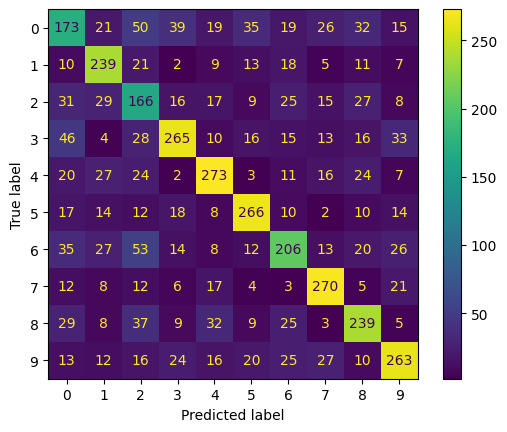

In [43]:
plot_confusion_matrix(vgg_13.module, test_dataloader, device)

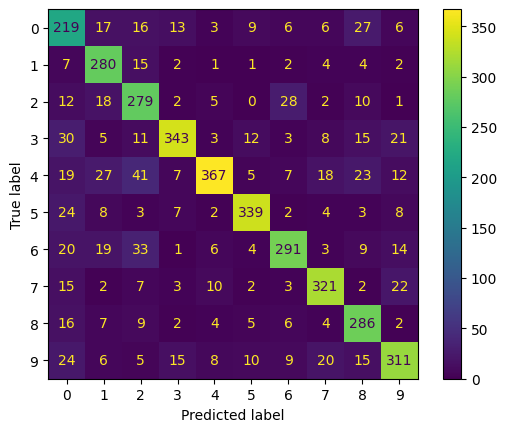

In [44]:
plot_confusion_matrix(vgg_13_bn.module, test_dataloader, device)